In [10]:
%reset -f
import sys
sys.path.insert(0, "..")
from wavhandler import *
from configs import DatasetConfiguration
from utils_train import *
from configs import *
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, make_scorer, log_loss
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import os
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
import seaborn as sb
import deepdish as dd

seed = 42
np.random.seed(seed=seed)

splitting = 'custom'
data_setting = 'rawflt'#'stftflt'
model_setting = 'dl4tsc_inc'#'DenseNet121'

clean = True

### data collecting

In [11]:
train = pd.read_csv(f"{TEMP_DATADIR}/df_train_{data_setting}_{model_setting}_{splitting}.csv", index_col=False)
X_train = train.x.tolist()
y_train = train.y.tolist()

In [12]:
val = pd.read_csv(f"{TEMP_DATADIR}/df_val_{data_setting}_{model_setting}_{splitting}.csv", index_col=False)
X_val = val.x.tolist()
y_val = val.y.tolist()

In [13]:
test = pd.read_csv(f"{TEMP_DATADIR}/df_test_{data_setting}_{model_setting}_{splitting}.csv", index_col=False)
X_test = test.x.tolist()
y_test = test.y.tolist()

In [14]:
print(f"train: \n{pd.Series(y_train).value_counts()}\n")
print(f"val: \n{pd.Series(y_val).value_counts()}\n")
print(f"test: \n{pd.Series(y_test).value_counts()}")

train: 
1    12377
0     3658
dtype: int64

val: 
1    4124
0    1221
dtype: int64

test: 
1    11457
0     1157
dtype: int64


## Loading MosquitoNet & Building top model

In [6]:
from tensorflow.keras import Input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

data = Dataset('Wingbeats')
print(data.target_classes)

dataset = data
splitting='random'
flag = ''
traincf = TrainConfiguration(nb_classes=6, setting=data_setting, model_name=f'MosquitoNET_{data_setting}_{model_setting}_{splitting}_{flag}')
using_conv2d = False
base_model = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, nb_classes=6).config
base_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

base_model.load_weights(traincf.top_weights_path)
base_model.trainable = False

if data_setting == 'rawflt':
    model = Sequential()
    for layer in base_model.layers[:-1]: # go through until last layer
        model.add(layer)
    #     print(layer.trainable)
    model.add(Dense(3, activation='softmax'))
elif data_setting == 'stftflt':
    base_output = base_model.layers[-2].output
    new_output = Dense(3, activation="softmax")(base_output)
    model = Model(inputs=base_model.inputs, outputs=new_output)

model.summary()

# # inputs = Input(shape=)
# inputs = Input(shape=base_model.input.shape[1:])
# x = base_model(inputs, training=False)
# # x =  GlobalAveragePooling2D()(x)
# # x = Dropout(0.2)(x)
# outputs = Dense(3)(x)
# model = Model(inputs, outputs)
# model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

['Ae. aegypti', 'Ae. albopictus', 'An. arabiensis', 'An. gambiae', 'C. pipiens', 'C. quinquefasciatus']
############ INPUT SHAPE:(5000, 1)
/home/kalfasyan/projects/wingbeat_frequencies/temp_data/


OSError: Unable to open file (unable to open file: name = '/home/kalfasyan/projects/wingbeat_frequencies/temp_data/MosquitoNET_rawflt_dl4tsc_inc_random_.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

### training top layer

In [7]:
traincf = TrainConfiguration(nb_classes=3, setting=data_setting, model_name=f"Flies_TL_{data_setting}_{model_setting}_{splitting}", monitor='val_accuracy', epochs=20)

h = model.fit(train_generator(X_train, y_train, 
                                    batch_size=traincf.batch_size,
                                    target_names=np.unique(y_test).tolist(),
                                    setting=traincf.setting,
                                     preprocessing_train_stats=''),
                    steps_per_epoch = int(math.ceil(float(len(X_train)) / float(traincf.batch_size))),
                    epochs = traincf.epochs,
                    validation_data = valid_generator(X_val, y_val,
                                                        batch_size=traincf.batch_size,
                                                        target_names=np.unique(y_test).tolist(),
                                                        setting=traincf.setting,
                                                         preprocessing_train_stats=''),
                    validation_steps=int(math.ceil(float(len(X_val))/float(traincf.batch_size))),
              callbacks=[traincf.callbacks_list])

Epoch 1/20
605/605 [==============================] - ETA: 0s - loss: 0.3494 - accuracy: 0.8670
Epoch 00001: val_accuracy improved from -inf to 0.90183, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/Flies_TL_stftflt_DenseNet121_random.h5
605/605 [==============================] - 112s 186ms/step - loss: 0.3494 - accuracy: 0.8670 - val_loss: 0.2821 - val_accuracy: 0.9018 - lr: 0.0010
Epoch 2/20
603/605 [============================>.] - ETA: 0s - loss: 0.2722 - accuracy: 0.9019
Epoch 00002: val_accuracy improved from 0.90183 to 0.91284, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/Flies_TL_stftflt_DenseNet121_random.h5
605/605 [==============================] - 31s 51ms/step - loss: 0.2719 - accuracy: 0.9020 - val_loss: 0.2527 - val_accuracy: 0.9128 - lr: 0.0010
Epoch 3/20
604/605 [============================>.] - ETA: 0s - loss: 0.2510 - accuracy: 0.9110
Epoch 00003: val_accuracy improved from 0.91284 to 0.92075, saving model to /ho

## Training whole model

In [8]:
from tensorflow.keras.optimizers import Adam

base_model.trainable = True
model.summary()

model.compile(
    optimizer=Adam(1e-5),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

traincf = TrainConfiguration(nb_classes=3, setting=data_setting, model_name=f"Flies_TL_{data_setting}_{model_setting}_{splitting}", monitor='val_accuracy', epochs=100)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 129, 120, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 135, 126, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 65, 60, 64)   3136        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 65, 60, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [9]:
h = model.fit(train_generator(X_train, y_train, 
                              batch_size=traincf.batch_size,
                              target_names=np.unique(y_test).tolist(),
                              setting=traincf.setting,
                              preprocessing_train_stats=''),
              steps_per_epoch = int(math.ceil(float(len(X_train)) / float(traincf.batch_size))),
              epochs = traincf.epochs,
              validation_data = valid_generator(X_val, y_val,
                                                batch_size=traincf.batch_size,
                                                target_names=np.unique(y_test).tolist(),
                                                setting=traincf.setting,
                                                preprocessing_train_stats=''),
              validation_steps=int(math.ceil(float(len(X_val))/float(traincf.batch_size))),
              callbacks=[traincf.callbacks_list])

Epoch 1/100
605/605 [==============================] - ETA: 0s - loss: 1.0316 - accuracy: 0.7941
Epoch 00001: val_accuracy improved from -inf to 0.89485, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/Flies_TL_stftflt_DenseNet121_random.h5
605/605 [==============================] - 206s 341ms/step - loss: 1.0316 - accuracy: 0.7941 - val_loss: 0.4029 - val_accuracy: 0.8949 - lr: 1.0000e-05
Epoch 2/100
605/605 [==============================] - ETA: 0s - loss: 0.3682 - accuracy: 0.8917
Epoch 00002: val_accuracy improved from 0.89485 to 0.91424, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/Flies_TL_stftflt_DenseNet121_random.h5
605/605 [==============================] - 62s 102ms/step - loss: 0.3682 - accuracy: 0.8917 - val_loss: 0.2842 - val_accuracy: 0.9142 - lr: 1.0000e-05
Epoch 3/100
605/605 [==============================] - ETA: 0s - loss: 0.2733 - accuracy: 0.9124
Epoch 00003: val_accuracy improved from 0.91424 to 0.93006, saving 

In [10]:
pred = model.predict_generator(valid_generator(X_test, y_test,
                                    batch_size=traincf.batch_size,
                                    target_names=np.unique(y_test).tolist(),
                                    setting=traincf.setting,
                                  preprocessing_train_stats=''),
                              steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))))

Instructions for updating:
Please use Model.predict, which supports generators.


In [11]:
from sklearn.metrics import balanced_accuracy_score, confusion_matrix

balanced_accuracy_score(y_true=y_test, y_pred=np.argmax(pred, axis=1))

0.8811349364759824

# USE PLOT_CONFUSION_MATRIX FROM SKLEARN.METRICS

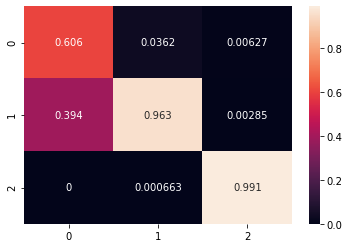

In [18]:
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix

cm = confusion_matrix(y_true=y_test, y_pred=np.argmax(pred, axis=1))
cm = cm.astype(np.float) / cm.astype(np.float).sum(axis=0)

sns.heatmap(cm, annot=True, fmt='.3g')



## result of rawflt

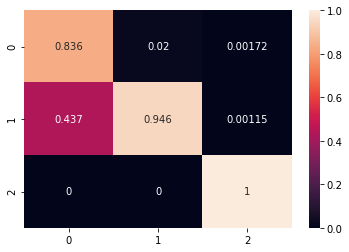

In [27]:
import seaborn as sns

cm = confusion_matrix(y_true=y_test, y_pred=np.argmax(pred, axis=1))
cm = cm.astype(np.float) / cm.astype(np.float).sum(axis=1)

sns.heatmap(cm, annot=True, fmt='.3g')

# Check if misclassifications are the same for normal training vs transfer learning